**Manual construction of a quantum circuit**
In this notebook we will show how we will genetically generate a quantum circuit. But before we do this the cell below shows how we can manually create a circuit, feel free to toy around with generating different structures of PQC's. The link below links to the library of qiskit which contains a comprehensive list of gates and operations. 
https://qiskit.org/documentation/apidoc/circuit_library.html

In [83]:
from qiskit.circuit import QuantumCircuit, Parameter, QuantumRegister
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

nr_of_qubits = 4
phi = Parameter("1")
phi2 = Parameter("2")
qr = QuantumRegister(nr_of_qubits)
circuit = QuantumCircuit(qr)
circuit.h([0])
circuit.h([1])
circuit.h([2])
circuit.h([3])
circuit.rx(phi,qubit=[0])
circuit.rx(phi2,qubit=[1])
print(circuit)
print(circuit.parameters)
value = np.random.random()
parameters = [value for _ in range(2*math.pi)]
print(circuit.bind_parameters(parameters))

       ┌───┐┌───────┐
q68_0: ┤ H ├┤ Rx(1) ├
       ├───┤├───────┤
q68_1: ┤ H ├┤ Rx(2) ├
       ├───┤└───────┘
q68_2: ┤ H ├─────────
       ├───┤         
q68_3: ┤ H ├─────────
       └───┘         
ParameterView([Parameter(1), Parameter(2)])
       ┌───┐┌───────────────────────┐
q68_0: ┤ H ├┤ Rx(0.349398938987163) ├
       ├───┤├───────────────────────┤
q68_1: ┤ H ├┤ Rx(0.349398938987163) ├
       ├───┤└───────────────────────┘
q68_2: ┤ H ├─────────────────────────
       ├───┤                         
q68_3: ┤ H ├─────────────────────────
       └───┘                         


The cell below shows how to create an experiment with different parameters. The parameters that aren't specified are selected from the `default_parameters.txt` file.

In [2]:
import pickle
import subprocess

# Experiment    
parameters = ["NR_OF_QUBITS=4,NR_OF_ISING_QUBITS=4,NR_OF_GATES=20","NR_OF_QUBITS=6,NR_OF_ISING_QUBITS=6,NR_OF_GATES=30","NR_OF_QUBITS=8,NR_OF_ISING_QUBITS=8,NR_OF_GATES=40","NR_OF_QUBITS=10,NR_OF_ISING_QUBITS=10,NR_OF_GATES=50"]
input = "python3 ./CLQGA.py --arguments "
pickle_name = "experiment_scaling_qubits"
####### Experiments
for i in range(0,len(parameters)):        
    exp_pickle_name = str(pickle_name) + "_" + str(i) 
    exp_input = str(input) + str(parameters[i]) + " --write " + str(exp_pickle_name)
    out = subprocess.call(exp_input, shell=True)

generation 1: 10934.23259401918
Expected runtime: 00:15:39
generation 2: 11341.035223246214
generation 3: 16425.108677889482
generation 4: 15476.385773530536
generation 5: 15056.240188366619
max gen reached!!


KeyboardInterrupt: 

The cell below unpacks the information gathered in during a run of the CLQGA. If you change the information that is being tracked this cell has to be changed.

In [103]:
from Experiments import saveLoad
from CLQGA import Individual
output = saveLoad("load","experiment_scaling_qubits_0", None)
# print(len(output))
experiment_population = output[0]
experiment_duration = output[1]
experiment_average_fitness_50_increment = output[2]
experiment_average_crowd_score_50_increment = output[3]
experiment_average_error_rate_50_increment = output[4]
# # for the individual the structure is [fitness, error, chromosome, current generation, unconfigured circuit, configured circuit]
experiment_best_individual = output[5]
# # # for the family the structure is [average elitism fitness, average elitism error, current generation, family set of chromosomes]
experiment_best_family = output[6]
# # # for the evolution the structure is [[best individual number of operation, best individual number of controlled gates], [family average number of operations, family average number of controlled operations]]
experiment_evolution = output[7]
# # # # ising instance
ising_instance = output[8]
print(len(experiment_population[0].chromosome)//9)

50


Helper function to find the lowest value of the 1d ising problem

In [105]:
from HelperCLQGA import compute_expected_energy, ising_1d_instance
def bruteforceLowestValue(h,j):
    def bool_to_state(integer):
    # Convert the 1/0 of a bit to +1/-1
        return 2*int(integer)-1

    r1=list([f'{i:0{len(h)}b}' for i in range(2**len(h))])
    best_energy = math.inf

    for k in range(0,len(r1)):
        current_energy = 0
        # r2[k] is the number of shots that have this result
        # r1[k] is the result as qubits (like 0001)
        # Energy of h
        current_energy += sum([bool_to_state(r1[k][bit_value])*h[bit_value] for bit_value in range(0,len(r1[k]))])
        # Energy of j
        current_energy += sum([bool_to_state(r1[k][bit_value])*bool_to_state(r1[k][bit_value+1])*j[bit_value] for bit_value in range(0,len(j))])
        if current_energy < best_energy:
            best_energy = current_energy

    return best_energy

# observable_h, observable_j = ising_1d_instance(4, None)
observable_h = ising_instance[0]
observable_j = ising_instance[1]
print(observable_h, observable_j)
exact_classical_solution = bruteforceLowestValue(observable_h,observable_j)
print(exact_classical_solution)

[1, 1, -1, -1, 1, 1, -1, -1, 1, -1] [-1, -1, 1, 1, -1, 1, 1, -1, 1]
-15


The cells below are used to generate graphs that plot the gradient vs delta energy

In [43]:
from HelperCLQGA import energy_from_circuit, genome_to_circuit
from qiskit_aer import AerSimulator
from scipy.optimize import minimize

backend_sim = AerSimulator()
upper_bound = 0.001
lower_bound = 0

# Data for the barcharts
## Data for the best individual
experiment_best_individual_graph_data = []
experiment_best_individual_graph_data_gradient = []
for individual in experiment_best_individual:
    ## if the object you are trying to evaluate has chromosomes use the next line
    # ind_ansatz,num_parameters = genome_to_circuit(individal.chromosome, 4, 20)
    ## if the object has a unconfigured circuit use the next lines!
    ind_ansatz = individual[4]
    num_parameters = individual[4].num_parameters
    parameters0 = [np.random.random()* (upper_bound-lower_bound)+lower_bound for _ in range(num_parameters)]
    def expectation_function(parameters):
        return energy_from_circuit(ind_ansatz.bind_parameters(parameters), ind_ansatz.num_qubits, observable_h, observable_j, 4000, backend_sim)
    vqe_result = minimize(expectation_function,parameters0, method="COBYLA", tol=1e-5, options={"maxiter":100**4})
    # For Gradient plotting
    experiment_best_individual_graph_data_gradient.append([individual[3],individual[0]/(1/(1+individual[1])*-vqe_result.fun),vqe_result.fun-exact_classical_solution])
    # For Fitness plotting
    experiment_best_individual_graph_data.append([individual[3],individual[0],vqe_result.fun-exact_classical_solution])

experiment_best_family_graph_data = []
experiment_best_family_graph_data_gradient = []

for family in experiment_best_family:
    delta_e = []
    for i in family[3]:
        ind_ansatz,num_parameters = genome_to_circuit(i, 10, len(i)//9)
        parameters0 = [np.random.random()* (upper_bound-lower_bound)+lower_bound for _ in range(num_parameters)]
        def expectation_function(parameters):
            return energy_from_circuit(ind_ansatz.bind_parameters(parameters), ind_ansatz.num_qubits, observable_h, observable_j, 4000, backend_sim)
        vqe_result = minimize(expectation_function,parameters0, method="COBYLA", tol=1e-5, options={"maxiter":100**4})
        delta_e.append(vqe_result.fun)
    experiment_best_family_graph_data.append([family[2],family[0],(sum(delta_e)/len(family[3])-exact_classical_solution)])
    experiment_best_family_graph_data_gradient.append([family[2],family[0]/((1/1.2)*-(sum(delta_e)/len(family[3]))),(sum(delta_e)/len(family[3])-exact_classical_solution)])

[[0, 12640.470703836027, 6.0120000000000005], [2, 14602.076034326823, 6.006], [7, 18713.137290434872, 4.016], [10, 19691.793368039336, 6.019], [20, 22969.560562669427, 4.019500000000001], [48, 23442.071304861205, 4.0169999999999995], [73, 23868.291648556107, 4.0], [74, 26910.363053744895, 4.0], [76, 28785.848841897838, 4.0120000000000005], [113, 30755.439973084598, 6.0435], [128, 38244.988393076346, 8.216000000000001], [213, 39192.58551432365, 4.003], [247, 39506.759130797844, 4.776], [251, 39597.08448573585, 4.0135000000000005], [260, 39794.34282046684, 4.009], [266, 42525.463439900304, 5.025499999999999], [280, 44616.14158169525, 4.0280000000000005], [281, 58973.09417099327, 4.132], [335, 63612.31458376175, 4.015000000000001]]
[[0, 6080.843124421144, 7.281049999999999], [2, 7033.042926302709, 7.8134], [3, 7773.914340431789, 7.8622], [7, 10246.515436416295, 7.280799999999999], [9, 10340.064058122567, 7.0521], [11, 10512.155190214678, 6.574200000000001], [15, 11065.362771773263, 6.7196

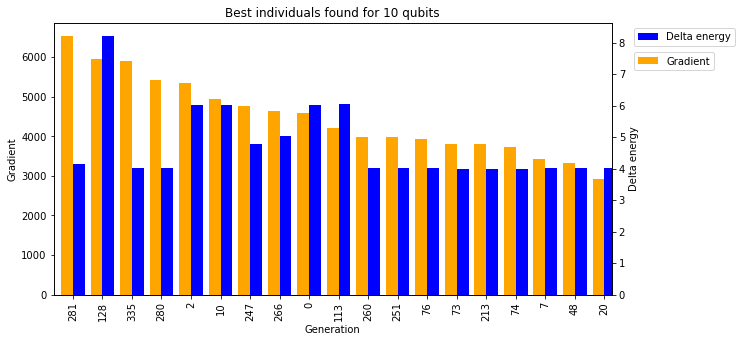

In [69]:
test = experiment_best_individual_graph_data_gradient

df = pd.DataFrame(test, columns=["Generations", "Gradient", "Delta energy"])
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx()
width = 0.4
df.iloc[:,2].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
df.iloc[:,1].plot(kind='bar', color='orange', ax=ax, width=width, position=1)

ax2.set_ylabel('Delta energy')
ax.set_ylabel('Gradient')
ax2.legend(loc='upper right', bbox_to_anchor=(1.23, 1))
ax.legend(loc='upper right', bbox_to_anchor=(1.192, 0.91))
ax.set_title("Best individuals found for 10 qubits")
ax.set_xticklabels(df.iloc[:,0], rotation=90)
# fig.subplots_adjust(bottom=0.3)
ax.set_xlabel("Generation")
fig.savefig("energy10qubitbestindividualgradient.png",dpi=300, bbox_inches="tight", facecolor='white')
plt.show()

The cells below are used to generate graphs that plot the fitness vs the number of optimisation steps

In [106]:
from HelperCLQGA import energy_from_circuit, genome_to_circuit
from qiskit_aer import AerSimulator
from scipy.optimize import minimize

backend_sim = AerSimulator()
upper_bound = 0.001
lower_bound = 0

# Data for the barcharts
## Data for the best individual
experiment_best_individual_graph_iters = []
for individual in experiment_best_individual:
    ## if the object you are trying to evaluate has chromosomes use the next line
    # ind_ansatz,num_parameters = genome_to_circuit(individal.chromosome, 4, 20)
    ## if the object has a unconfigured circuit use the next lines!
    ind_ansatz = individual[4]
    num_parameters = individual[4].num_parameters
    parameters0 = [np.random.random()* (upper_bound-lower_bound)+lower_bound for _ in range(num_parameters)]
    def expectation_function(parameters):
        return energy_from_circuit(ind_ansatz.bind_parameters(parameters), ind_ansatz.num_qubits, observable_h, observable_j, 4000, backend_sim)
    vqe_result = minimize(expectation_function,parameters0, method="COBYLA", tol=1e-5, options={"maxiter":100**4})
    # For Fitness plotting vs Minimise iterations
    experiment_best_individual_graph_iters.append([individual[3],individual[0],vqe_result.nfev])

experiment_best_family_graph_iters = []

for family in experiment_best_family:
    nfev = []
    for i in family[3]:
        ind_ansatz,num_parameters = genome_to_circuit(i, 10, len(i)//9)
        parameters0 = [np.random.random()* (upper_bound-lower_bound)+lower_bound for _ in range(num_parameters)]
        def expectation_function(parameters):
            return energy_from_circuit(ind_ansatz.bind_parameters(parameters), ind_ansatz.num_qubits, observable_h, observable_j, 4000, backend_sim)
        vqe_result = minimize(expectation_function,parameters0, method="COBYLA", tol=1e-5, options={"maxiter":100**4})
        nfev.append(int(vqe_result.nfev))
    experiment_best_family_graph_iters.append([family[2],family[0],(sum(nfev)/len(family[3]))])
print(experiment_best_individual_graph_iters)
print(experiment_best_family_graph_iters)

[[0, 12640.470703836027, 149], [2, 14602.076034326823, 136], [7, 18713.137290434872, 280], [10, 19691.793368039336, 154], [20, 22969.560562669427, 251], [48, 23442.071304861205, 272], [73, 23868.291648556107, 213], [74, 26910.363053744895, 215], [76, 28785.848841897838, 205], [113, 30755.439973084598, 236], [128, 38244.988393076346, 94], [213, 39192.58551432365, 243], [247, 39506.759130797844, 313], [251, 39597.08448573585, 205], [260, 39794.34282046684, 206], [266, 42525.463439900304, 201], [280, 44616.14158169525, 198], [281, 58973.09417099327, 164], [335, 63612.31458376175, 115]]
[[0, 6080.843124421144, 205.4], [2, 7033.042926302709, 223.8], [3, 7773.914340431789, 211.9], [7, 10246.515436416295, 237.8], [9, 10340.064058122567, 220.3], [11, 10512.155190214678, 194.1], [15, 11065.362771773263, 209.9], [20, 12757.21810690005, 225.9], [47, 13458.975845284314, 221.6], [57, 14759.865177635755, 211.8], [73, 15079.083092920362, 246.5], [96, 15350.367643066882, 255.1], [97, 15439.74617410371

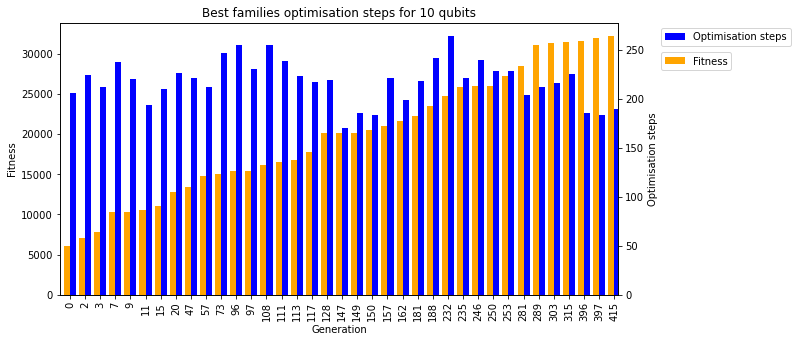

In [108]:
test = experiment_best_family_graph_iters

df = pd.DataFrame(test, columns=["Generations", "Fitness", "Optimisation steps"])
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx()
width = 0.4
df.iloc[:,2].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
df.iloc[:,1].plot(kind='bar', color='orange', ax=ax, width=width, position=1)

ax2.set_ylabel('Optimisation steps')
ax.set_ylabel('Fitness')
ax2.legend(loc='upper right', bbox_to_anchor=(1.318, 1))
ax.legend(loc='upper right', bbox_to_anchor=(1.212, 0.91))
ax.set_title("Best families optimisation steps for 10 qubits")
ax.set_xticklabels(df.iloc[:,0], rotation=90)
# fig.subplots_adjust(bottom=0.3)
ax.set_xlabel("Generation")
fig.savefig("energy10qubitbestfamilysteps.png",dpi=300, bbox_inches="tight", facecolor='white')
plt.show()

If you want to visualise a chromosome use the following line of code

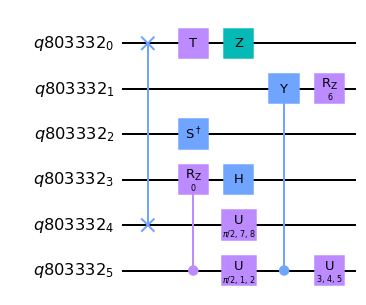

In [49]:
nr_of_qubits = 6
nr_of_gates = 20
chromosome = experiment_population[3].chromosome
genome_to_circuit(experiment_population[3].chromosome, nr_of_qubits, nr_of_gates)[0].draw(output='mpl', idle_wires=False)